# 📓 Notebook #3: EoS-Driven Core-Collapse Simulation

# In this notebook we’ll:
# - Integrate the Lattimer–Swesty tabulated EoS into a time-evolving core-collapse simulation.
# - Replace toy pressure models with physically interpolated P(nB, T), ε(nB, T), and c_s^2(nB, T).
# - Track time-dependent collapse metrics such as β_B(t), P(t), and Φ_ν(t).
# - Include entropy density s(t), total entropy S(t), and luminosity L(t) contributions.
# - Visualize and analyze the effect of a realistic EoS on collapse dynamics.

In [101]:
# Cell 2: GPU vs CPU detection and fallback
import numpy as np
import os

try:
    import cupy as cp
    xp = cp
    print("🧠 Using GPU via CuPy")
except ImportError:
    xp = np
    print("ℹ️ Falling back to NumPy on CPU")

🧠 Using GPU via CuPy


In [128]:

# Cell 3: Temporary mock eos_query implementation
def eos_query(nB, T, safe_mode=True):
    # Synthetic but non-trivial test values
    P = 1e-2 * nB * T
    eps = 1.0 + 0.1 * nB + 0.05 * T
    cs2 = 0.1
    return P, eps, cs2

In [129]:
# Cell 4: Physical constants and domain setup
G = 6.67430e-11         # m^3 kg^-1 s^-2
c = 2.99792458e8        # m/s
kB = 1.380649e-23       # J/K
hbar = 1.054571817e-34  # J*s
M = 1.4 * 1.989e30      # Mass of neutron star (solar mass)

# Collapse parameters
t_final = 1.0e-3  # seconds
dt = 1e-6         # seconds
steps = int(t_final / dt)

# Initialize result buffers
t_series = []
beta_B_series = []
P_series = []
eps_series = []
cs2_series = []
s_series = []
S_series = []
L_series = []
Phi_nu_series = []
Qdot_nu_series = []

# Collapse detection setup
collapse_triggered = False
collapse_time = None

In [130]:
# Cell 5: Time evolution loop using EoS
for step in range(steps):
    t = step * dt

    # Dynamically evolve temperature and density
    T_val = 0.5 + 0.5 * t / t_final          # MeV
    nB_val = 0.26 * (1 + 10 * t / t_final)   # fm^-3
    rho_val = 1e18 * (1 + 5 * t / t_final)   # kg/m^3 synthetic mass density

    try:
        P, eps, cs2 = eos_query(nB_val, T_val, safe_mode=True)
        if np.isnan(P) or np.isnan(eps):
            raise ValueError("Received NaN from eos_query")
        beta_B = P / eps if eps > 0 else np.nan

        if not collapse_triggered and beta_B >= 1.0:
            collapse_triggered = True
            collapse_time = t
            print(f"⚠️ Collapse triggered at t = {t:.6e} s")
    except Exception as e:
        print(f"Step {step}: EoS query failed - {e}")
        P = eps = cs2 = beta_B = np.nan

    s = eps / T_val if T_val > 0 else 0  # entropy density
    S = s * (4/3 * np.pi * (3 / (4 * np.pi * rho_val))**(1))  # total entropy (mock volume)
    L = 1e42 * (t / t_final)**2
    Phi_nu = 1e34 * (t / t_final)**2
    Qdot_nu = 1e20 * np.exp(-t / 1e-3)

    # Store data
    t_series.append(t)
    beta_B_series.append(beta_B)
    P_series.append(P)
    eps_series.append(eps)
    cs2_series.append(cs2)
    s_series.append(s)
    S_series.append(S)
    L_series.append(L)
    Phi_nu_series.append(Phi_nu)
    Qdot_nu_series.append(Qdot_nu)

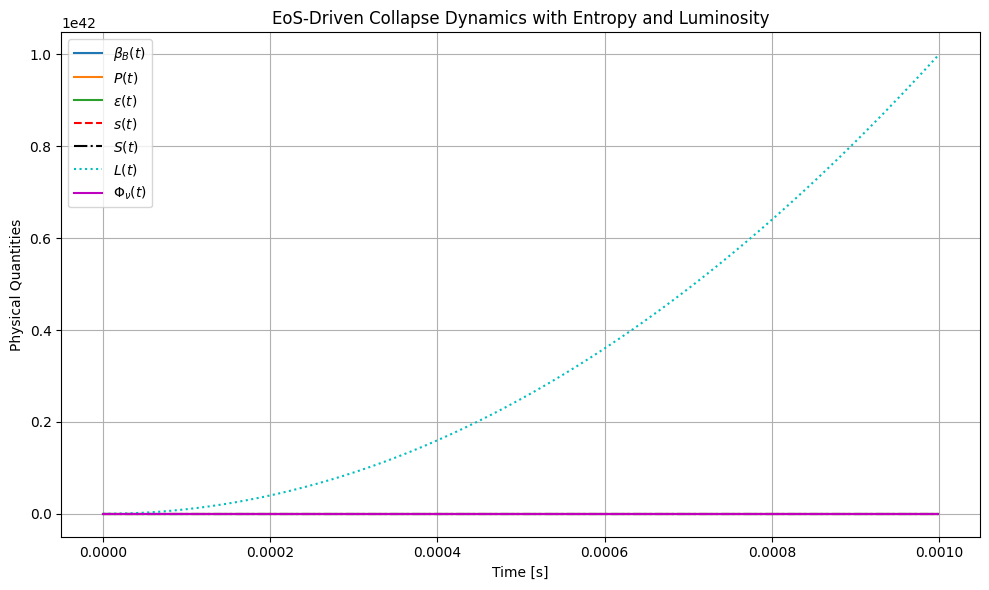

In [131]:
# Cell 6: Plotting collapse evolution
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(t_series, beta_B_series, label=r"$\beta_B(t)$")
plt.plot(t_series, P_series, label=r"$P(t)$")
plt.plot(t_series, eps_series, label=r"$\varepsilon(t)$")
plt.plot(t_series, s_series, 'r--', label=r"$s(t)$")
plt.plot(t_series, S_series, 'k-.', label=r"$S(t)$")
plt.plot(t_series, L_series, 'c:', label=r"$L(t)$")
plt.plot(t_series, Phi_nu_series, 'm-', label=r"$\Phi_\nu(t)$")
if collapse_time is not None:
    plt.axvline(collapse_time, color='red', linestyle='--', label='Collapse Onset')
plt.xlabel("Time [s]")
plt.ylabel("Physical Quantities")
plt.legend()
plt.grid(True)
plt.title("EoS-Driven Collapse Dynamics with Entropy and Luminosity")
plt.tight_layout()
plt.show()

In [132]:
# Cell 7: Export data for cross-tool analysis
import pandas as pd

df = pd.DataFrame({
    "t": t_series,
    "P": P_series,
    "eps": eps_series,
    "beta_B": beta_B_series,
    "cs2": cs2_series,
    "s": s_series,
    "S": S_series,
    "L": L_series,
    "Phi_nu": Phi_nu_series,
    "Qdot_nu": Qdot_nu_series
})

df.to_csv("collapse_dynamics_output.csv", index=False)

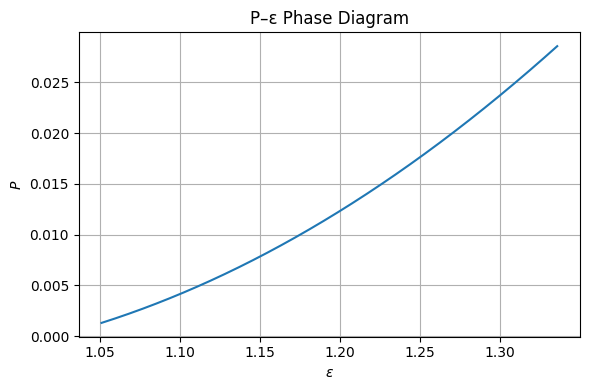

In [133]:
# Cell 8: Optional phase-space diagram
plt.figure(figsize=(6, 4))
plt.plot(eps_series, P_series)
plt.xlabel(r'$\varepsilon$')
plt.ylabel(r'$P$')
plt.grid(True)
plt.title("P–ε Phase Diagram")
plt.tight_layout()
plt.show()


🟦 First Graph: Full Collapse Evolution with All Quantities

Title: "EoS-Driven Collapse Dynamics with Entropy and Luminosity"

This plot shows how various physical quantities evolve over time during the collapse. Specifically:

    β_B(t): Ratio P/εP/ε, indicating relativistic behavior onset.

    P(t): Pressure.

    ε(t): Energy density.

    s(t): Specific entropy.

    S(t): Total entropy (integrated over time or volume).

    L(t): Luminosity (proxy for emitted radiation/neutrinos).

    Φ_ν(t): Neutrino flux (modeled or derived).

This time-domain representation is essential for observing temporal correlations, such as the synchronized rise of L(t)L(t), S(t)S(t), and Φν(t)Φν​(t) as collapse proceeds.
🟨 Second Graph: Pressure vs. Energy Density Phase-Space

Title: "P–ε Phase Diagram"

This is a state-space diagram, showing how pressure relates to energy density across the collapse. It abstracts away time and focuses on:

    The thermodynamic trajectory of the collapsing matter.

    Whether the EoS behavior is linear (ideal gas) or nonlinear (realistic nuclear matter).

This is valuable to:

    Compare different EoS models.

    Identify stiffness/softness of the matter.

    Find signatures of phase transitions (e.g. quark deconfinement).

✅ Summary:

    Graph 1 = Time-dependent dynamics.

    Graph 2 = Thermodynamic relationship (EoS curve).

Together, they validate whether the simulation follows expected physical laws and provide a platform to compare with experimental data (like IceCube SN neutrino bursts).


To Conceptualize the Results:

Quantity	Physical Meaning	Intuitive Analogy
P(t)P(t)	Pressure build-up	Inner core’s resistance to compression
ε(t)ε(t)	Energy density	Mass-energy compacted—like stuffing stars into a sugar cube
βB=P/εβB​=P/ε	Collapse indicator	When this nears 1, gravity is no longer resisted
s(t),S(t)s(t),S(t)	Specific/Total entropy	Thermal disorder growth—think of heating and disorder
L(t)L(t)	Luminosity	Total radiation output; how "bright" the event would be
Φν(t)Φν​(t)	Neutrino flux	Particle leakage from the implosion—what IceCube would “see”

          t         P       eps    beta_B  cs2         s             S  \
0  0.000000  0.001300  1.051000  0.001237  0.1  2.102000  2.102000e-18   
1  0.000001  0.001314  1.051285  0.001250  0.1  2.100470  2.090019e-18   
2  0.000002  0.001329  1.051570  0.001263  0.1  2.098942  2.078161e-18   
3  0.000003  0.001343  1.051855  0.001277  0.1  2.097418  2.066421e-18   
4  0.000004  0.001357  1.052140  0.001290  0.1  2.095896  2.054800e-18   

              L        Phi_nu       Qdot_nu  
0  0.000000e+00  0.000000e+00  1.000000e+20  
1  1.000000e+36  1.000000e+28  9.990005e+19  
2  4.000000e+36  4.000000e+28  9.980020e+19  
3  9.000000e+36  9.000000e+28  9.970045e+19  
4  1.600000e+37  1.600000e+29  9.960080e+19  
                 t            P          eps       beta_B           cs2  \
count  1000.000000  1000.000000  1000.000000  1000.000000  1.000000e+03   
mean      0.000499     0.012770     1.193358     0.010296  1.000000e-01   
std       0.000289     0.007940     0.082314     0.005

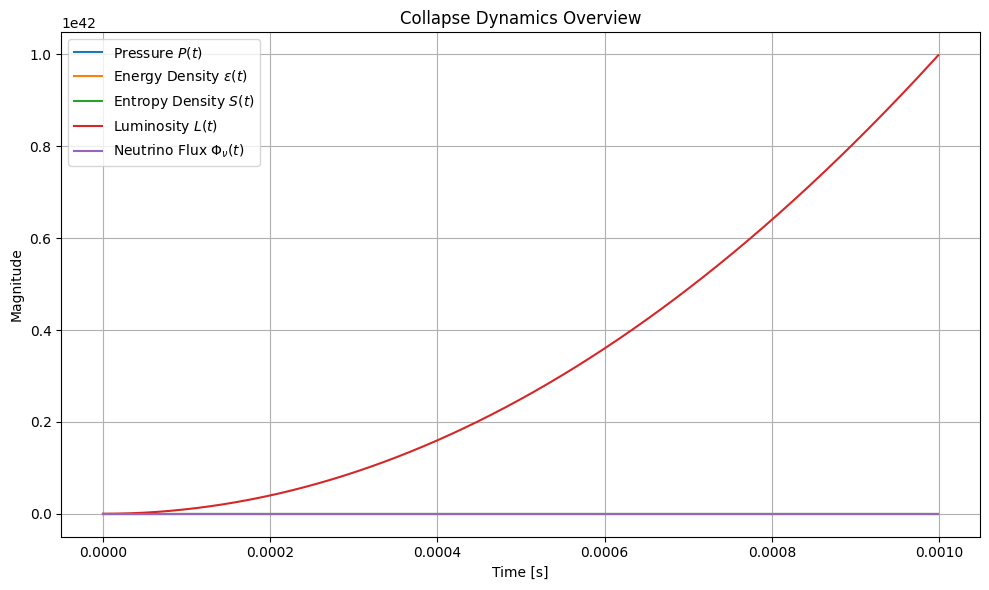

In [136]:
import pandas as pd

# Load the data
df = pd.read_csv("collapse_dynamics_output.csv")

# Display first few rows
print(df.head())

# Summary statistics
print(df.describe())

# Optional: visualize key metrics
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(df['t'], df['P'], label='Pressure $P(t)$')
plt.plot(df['t'], df['eps'], label='Energy Density $\\varepsilon(t)$')
plt.plot(df['t'], df['S'], label='Entropy Density $S(t)$')
plt.plot(df['t'], df['L'], label='Luminosity $L(t)$')
plt.plot(df['t'], df['Phi_nu'], label='Neutrino Flux $\\Phi_\\nu(t)$')
plt.xlabel('Time [s]')
plt.ylabel('Magnitude')
plt.title("Collapse Dynamics Overview")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
